In [1]:
from pathlib import Path
from collections import Counter, defaultdict
from itertools import chain

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import catboost
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, space_eval

In [2]:
data_path = Path('data')
songs = pd.read_csv(data_path / 'songs.csv')
listens = pd.read_csv(data_path / 'train.csv')
members = pd.read_csv(data_path / 'members.csv')

In [3]:
users_counter = Counter(listens['msno'])
active_users = [u for u, c in users_counter.most_common() if c > 50]
user_ids = {u: i for i, u in enumerate(active_users)}
n_users = len(active_users)
songs_counter = Counter(listens['song_id'])
popular_songs = [s for s, c in songs_counter.most_common() if c > 50]
song_ids = {s: i for i, s in enumerate(popular_songs)}
n_songs = len(popular_songs)

In [4]:
listens['uid'] = listens['msno'].apply(lambda u: user_ids.get(u, -1))
listens['sid'] = listens['song_id'].apply(lambda s: song_ids.get(s, -1))

In [5]:
genre_counter = Counter(
    g
    for x in songs['genre_ids'] if isinstance(x, str)
    for g in x.split('|')
)
popular_genres = {g for g, c in genre_counter.most_common() if c >= 100}

def extract_genre(genre_ids):
    if not isinstance(genre_ids, str):
        return None
    genres_ids = [g for g in genre_ids.split('|') if g in popular_genres]
    return genres_ids[0] if genres_ids else None
    
listens['gid'] = listens.join(songs.set_index('song_id'), on='song_id', how='left')['genre_ids']\
    .apply(extract_genre)\
    .reset_index()['genre_ids']

In [6]:
artist_names = songs['artist_name'].unique()
artist_ids = {a: i for i, a in enumerate(artist_names)}
songs['aid'] = songs['artist_name'].apply(artist_ids.get)

In [7]:
users_songs_mask = (listens['uid'] >= 0) & (listens['sid'] >= 0)
data = listens[users_songs_mask] \
        .join(members[['msno', 'gender', 'bd']].set_index('msno'), on='msno', how='left') \
        .join(songs[['song_id', 'aid']].set_index('song_id'), on='song_id', how='left')

data['gender'] = data['gender'].fillna('unk')
data['source_screen_name'] = data['source_screen_name'].fillna('unk')
data['source_system_tab'] = data['source_system_tab'].fillna('unk')
data['source_type'] = data['source_type'].fillna('unk')
data['gid'] = data['gid'].fillna(-1)
data['ts'] = np.arange(len(data))

val_mask = (np.random.randint(0, 5, len(data)) == 0)
data_train = data[~val_mask]
data_val = data[val_mask]
cus = set(data_train['uid']) & set(data_val['uid'])
css = set(data_train['sid']) & set(data_val['sid'])
data_train = data_train[data_train['uid'].apply(cus.__contains__) & data_train['sid'].apply(css.__contains__)]
data_val = data_val[data_val['uid'].apply(cus.__contains__) & data_val['sid'].apply(css.__contains__)]

In [8]:
def calc_roc(pt):
    pred, target = np.array(list(pt.values)).T
    if len(set(target)) < 2:
        return -1
    return roc_auc_score(target, pred)


def evaluate(data, model):
    pred = model.predict(data)
    pred_data = data[['uid', 'target']].assign(pred=pred)
    pred_data['pt'] = pred_data[['pred', 'target']].apply(tuple, axis=1)
    user_ausc = pred_data[['uid', 'pt']].groupby('uid').agg(calc_roc)['pt']
    return user_ausc[user_ausc >= 0].mean()
    

def cross_validate(data, model_factory, n_folds=5):
    fold_ids = np.random.randint(0, n_folds, len(data))
    train_roc_aucs, val_roc_aucs = [], []
    for i in range(n_folds):
        val_mask = fold_ids == i
        train_data = data[~val_mask]
        val_data = data[val_mask]
        train_users, val_users = set(train_data['uid']), set(val_data['uid'])
        cus = train_users & val_users
        train_songs, val_songs = set(train_data['sid']), set(val_data['sid'])
        css = train_songs & val_songs
        train_data = train_data[train_data['uid'].apply(cus.__contains__) & train_data['sid'].apply(css.__contains__)]
        val_data = val_data[val_data['uid'].apply(cus.__contains__) & val_data['sid'].apply(css.__contains__)]
        
        model = model_factory().fit(train_data)
        train_roc_auc = evaluate(train_data, model)
        val_roc_auc = evaluate(val_data, model)
        train_roc_aucs.append(train_roc_auc)
        val_roc_aucs.append(val_roc_auc)
        print(f'Fold: {i}, ROC AUC: train {train_roc_auc:.3f} val {val_roc_auc:.3f}')
    print(f'Average ROC AUC: train {np.mean(train_roc_aucs):.3f} val {np.mean(val_roc_aucs):.3f}')

In [9]:
def collect_listens(data):
    users_listened = defaultdict(list)
    songs_listeners = defaultdict(list)
    users_degrees = np.zeros(n_users, dtype=np.int32)
    songs_degrees = np.zeros(n_songs, dtype=np.int32)
    for _, u, s in data[['uid', 'sid']].itertuples():
        users_listened[u].append(s)
        songs_listeners[s].append(u)
        users_degrees[u] += 1
        songs_degrees[s] += 1
    return users_listened, songs_listeners, users_degrees, songs_degrees
    
def make_edges_list(edges_dict):
    rows, cols, data = [], [], []
    for v, neighbours in edges_dict.items():
        rows.extend([v] * len(neighbours))
        cols.extend(range(len(neighbours)))
        data.extend(neighbours)
    return csr_matrix((data, (rows, cols)))

In [10]:
def make_walk_step(vs, degrees, edges):
    edge_indexes = np.zeros(len(vs), dtype=np.int32)
    mask = degrees[vs] > 0
    edge_indexes[mask] = np.random.randint(degrees[vs][mask])
    return np.array(edges[vs, edge_indexes]).ravel()

def run_walks(users, users_edges, songs_edges, users_degrees, songs_degrees, steps, walks_per_user):
    pos = np.array(users).repeat(walks_per_user)
    for _ in range(steps):
        pos = make_walk_step(pos, users_degrees, users_edges)
        pos = make_walk_step(pos, songs_degrees, songs_edges)
    return pos.reshape((-1, walks_per_user))

In [11]:
class PageRank:
    def __init__(self):
        self.user_song_reaches = {}
        
    def fit(self, data):
        users_listened, songs_listeners, users_degrees, songs_degrees = collect_listens(data[data['target'] == 1])
        users_edges = make_edges_list(users_listened)
        songs_edges = make_edges_list(songs_listeners)
        user_list = list(set(data['uid']))
        reached = run_walks(user_list, users_edges, songs_edges, users_degrees, songs_degrees, 15, 500)
        self.user_song_reaches = {}
        for u, u_reaches in zip(user_list, reached):
            r_songs, reaches = np.unique(u_reaches, return_counts=True)
            for s, rs in zip(r_songs, reaches):
                self.user_song_reaches[(u, s)] = rs
        return self
        
    def predict(self, data):
        return [self.user_song_reaches.get((u, s), 0) for _, u, s in data[['uid', 'sid']].itertuples()]

In [12]:
tdf = pd.DataFrame(np.arange(12).reshape((3, 4)))
tdf.columns = [f'u{i}' for i in tdf.columns]
tdf

,u0,u1,u2,u3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


In [12]:
class HistoryFeatureCalculator:
    def __init__(self, f1, f2):
        self.history = []
        self.f1 = f1
        self.f2 = f2
    
    def fit(self, data):
        self.history = list(zip(
            data[self.f1].values, data[self.f2].values, data['ts'], data['target']))
        return self
        
    def predict(self, data):
        queries = list(zip(data[self.f1].values, data[self.f2].values, data['ts']))
        mixed_history = sorted(self.history + queries, key=lambda p: p[2] if len(p) == 3 else p[2] + .5)
        pos_res, neg_res = [], []
        pos_counter, neg_counter = Counter(), Counter()
        for p in mixed_history:
            counter_key = p[:2]
            if len(p) == 3:
                pos_res.append(pos_counter[counter_key])
                neg_res.append(neg_counter[counter_key])
            else:
                if p[3]:
                    pos_counter.update((counter_key,))
                else:
                    neg_counter.update((counter_key,))
        return pos_res, neg_res

In [13]:
BASIC_FEATURES = ['bd', 'gid', 'gender', 'source_screen_name', 'source_system_tab', 'source_type']
CAT_FEATURES = ['gid', 'gender', 'source_screen_name', 'source_system_tab', 'source_type']


def calc_gb_features(pr, hist_calc_art, hist_calc_gen, data):
    art_pos, art_neg = hist_calc_art.predict(data)
    gen_pos, gen_neg = hist_calc_gen.predict(data)
    return data[BASIC_FEATURES] \
                .assign(pr=pr.predict(data)) \
                .assign(ap=art_pos) \
                .assign(an=art_neg) \
                .assign(gp=gen_pos) \
                .assign(gn=gen_neg)

In [14]:
pr = PageRank().fit(data_train)
hist_calc_art = HistoryFeatureCalculator('uid', 'aid').fit(data_train)
hist_calc_gen = HistoryFeatureCalculator('uid', 'gid').fit(data_train)

gbm_x_train = calc_gb_features(pr, hist_calc_art, hist_calc_gen, data_train)
gbm_x_val = calc_gb_features(pr, hist_calc_art, hist_calc_gen, data_val)

In [66]:
def gb_obj(params):
    model = catboost.CatBoostClassifier(task_type='GPU', logging_level='Silent', **params)
    model.fit(gbm_x_train, data_train['target'], cat_features=CAT_FEATURES)
    
    model_pred = model.predict_proba(gbm_x_val)[:, 1]
    pred_data = data_val[['uid', 'target']].assign(pred=model_pred)
    pred_data['pt'] = pred_data[['pred', 'target']].apply(tuple, axis=1)
    user_ausc = pred_data[['uid', 'pt']].groupby('uid').agg(calc_roc)['pt']
    return -user_ausc[user_ausc >= 0].mean()

gbm_n_estimators_options = [60, 100]
gbm_max_depth_options = [6, 8, 10]
gb_param_space = {
    'n_estimators': hp.choice('n_estimators', gbm_n_estimators_options),
    'max_depth': hp.choice('max_depth', gbm_max_depth_options),
    'learning_rate': hp.loguniform('learning_rate', np.log(.05), np.log(1)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(10))
}

gbm_best = fmin(gb_obj, gb_param_space, algo=tpe.suggest, max_evals=20)

gbm_n_estimators = gbm_n_estimators_options[gbm_best['n_estimators']]
gbm_max_depth = gbm_max_depth_options[gbm_best['max_depth']]
gbm_learning_rate = gbm_best['learning_rate']
gbm_l2_leaf_reg = gbm_best['l2_leaf_reg']

gbm_n_estimators, gbm_max_depth, gbm_learning_rate, gbm_l2_leaf_reg

100%|███████████████████████████████████████████████| 20/20 [18:24<00:00, 55.23s/trial, best loss: -0.7099203597436984]


(100, 10, 0.23517883705005213, 1.7785174894862406)

In [67]:
class GBModel:
    def __init__(self):
        self.clf = catboost.CatBoostClassifier(task_type='GPU', logging_level='Silent', 
                n_estimators=gbm_n_estimators, max_depth=gbm_max_depth, learning_rate=gbm_learning_rate, 
                                               l2_leaf_reg=gbm_l2_leaf_reg)
        self.pr = PageRank()
        self.hist_calc_art = HistoryFeatureCalculator('uid', 'aid')
        self.hist_calc_gen = HistoryFeatureCalculator('uid', 'gid')
    
    def fit(self, data):
        self.pr.fit(data)
        self.hist_calc_art.fit(data)
        self.hist_calc_gen.fit(data)
        
        x = calc_gb_features(self.pr, self.hist_calc_art, self.hist_calc_gen, data)
        y = data['target']
        self.clf.fit(x, y, cat_features=CAT_FEATURES)
        return self
    
    def predict(self, data):
        x = calc_gb_features(self.pr, self.hist_calc_art, self.hist_calc_gen, data)
        return self.clf.predict_proba(x)[:, 1]

In [72]:
cross_validate(data, GBModel)

Fold: 0, ROC AUC: train 0.697 val 0.711
Fold: 1, ROC AUC: train 0.698 val 0.709
Fold: 2, ROC AUC: train 0.698 val 0.709
Fold: 3, ROC AUC: train 0.698 val 0.710
Fold: 4, ROC AUC: train 0.698 val 0.708
Average ROC AUC: train 0.698 val 0.709


In [15]:
import torch
from torch import nn
import torch.nn.functional as F

In [16]:
def make_walks(users, users_edges, songs_edges, users_degrees, songs_degrees, steps, walks_per_user):
    pos = np.array(users).repeat(walks_per_user)
    trace = [pos]
    for _ in range(steps):
        pos = make_walk_step(pos, users_degrees, users_edges)
        trace.append(pos)
        pos = make_walk_step(pos, songs_degrees, songs_edges)
        trace.append(pos)
    return np.hstack([np.expand_dims(pos, 1) for pos in trace])

In [17]:
class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, context_max_dist, n_users, walks, shuffle=False):
        self.walks = walks.copy().astype(np.int64)
        self.walks[:, 1::2] += n_users
        pairs = []
        self.max_dist = context_max_dist
        self.shuffle = shuffle
        for walk in self.walks:
            for target_index, target in enumerate(walk):
                for neighbour in walk[max(0, target_index - self.max_dist):target_index + self.max_dist + 1]:
                    if target != neighbour:
                        pairs.append((target, neighbour))
        self.pairs = np.array(pairs)
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
        return tuple(self.pairs[index])

In [18]:
class SkipGramNegativeSampler:
    def __init__(self, data, n_users):
        user_samples = data['uid'].values
        song_samples = data['sid'].values + n_users
        self.samples = np.concatenate((user_samples, song_samples))
    
    def sample(self, n):
        return torch.LongTensor(np.random.choice(self.samples, n))

    
class SkipGramLoss(nn.Module):
    def __init__(self, tgt_embedding, ctxt_embedding, neg_sampler, l2_reg, device='cpu'):
        super().__init__()
        self.neg_sampler = neg_sampler
        self.tgt_embedding = tgt_embedding.to(device)
        self.ctxt_embedding = ctxt_embedding.to(device)
        self.device = device
        self.l2_reg = l2_reg
        
    def forward(self, target, positives):
        negatives = self.neg_sampler.sample(len(target)).to(self.device)
        target, positives = target.to(self.device), positives.to(self.device)
        
        tgt_embeddings = self.tgt_embedding(target)
        pos_embeddings = self.ctxt_embedding(positives)
        neg_embeddings = self.ctxt_embedding(negatives)
        
        pos_sim_ls = torch.sigmoid(-torch.sum(tgt_embeddings * pos_embeddings, dim=1)).mean()
        neg_sim_ls = torch.sigmoid(torch.sum(tgt_embeddings * neg_embeddings, dim=1)).mean()
        return pos_sim_ls + neg_sim_ls + \
            torch.norm(tgt_embeddings, dim=1).mean() * self.l2_reg + \
            torch.norm(pos_embeddings, dim=1).mean() * self.l2_reg + \
            torch.norm(neg_embeddings, dim=1).mean() * self.l2_reg

In [19]:
def train_skip_gram(loss_function, data, n_epochs, lr_step, lr_gamma, lr, *, quiet=False, device='cpu'):
    optimizer = torch.optim.Adam(loss_function.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
    for epoch in range(n_epochs):
        losses = []
        for target, positive in data:
            target, positive = target.to(device), positive.to(device)
            optimizer.zero_grad()
            loss = loss_function(target, positive)
            loss.backward()
            optimizer.step()
            losses.append(loss.detach())
        lr_scheduler.step()
        if not quiet:
            avg_loss = torch.tensor(losses).mean()
            print(f'Epoch {epoch} loss {avg_loss:.3f}')

In [20]:
EMBEDDING_DIM = 20
device = 'cuda'

In [21]:
def walks_from_data(data):
    users_listened, songs_listeners, users_degrees, songs_degrees = collect_listens(data[data['target'] == 1])
    users_edges = make_edges_list(users_listened)
    songs_edges = make_edges_list(songs_listeners)
    user_list = list(set(data['uid']))
    return make_walks(user_list, users_edges, songs_edges, users_degrees, songs_degrees, 10, 25)

In [22]:
class SkipGramModel:
    def __init__(self):
        self.user_embedding = None
        self.song_embedding = None
    
    def fit(self, data):
        walks = walks_from_data(data)
        
        dataset = SkipGramDataset(2, n_users, walks, shuffle=True)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=2 ** 21)
        
        tgt_emb = nn.Embedding(n_users + n_songs, EMBEDDING_DIM)
        ctxt_emb = nn.Embedding(n_users + n_songs, EMBEDDING_DIM)
        neg_sampler = SkipGramNegativeSampler(data, n_users)
        loss_function = SkipGramLoss(tgt_emb, ctxt_emb, neg_sampler, .01, device)
        train_skip_gram(loss_function, dataloader, 5, 1, .7, 1., quiet=True, device=device)
        
        all_vectors = tgt_emb.weight.data.cpu()
        self.user_embedding = all_vectors[:n_users]
        self.song_embedding = all_vectors[n_users:]
        return self
    
    def predict(self, data):
        users = data['uid'].values
        songs = data['sid'].values
        with torch.no_grad():
            prediction = torch.sigmoid(torch.sum(self.user_embedding[users] * self.song_embedding[songs], axis=1))
        return prediction.numpy()

In [85]:
cross_validate(data, SkipGramModel)

Fold: 0, ROC AUC: train 0.570 val 0.555
Fold: 1, ROC AUC: train 0.571 val 0.556
Fold: 2, ROC AUC: train 0.571 val 0.556
Fold: 3, ROC AUC: train 0.570 val 0.556
Fold: 4, ROC AUC: train 0.571 val 0.557
Average ROC AUC: train 0.571 val 0.556


In [24]:
sgm = SkipGramModel().fit(data_train)

In [26]:
stack_x_train = gbm_x_train.assign(sg=sgm.predict(data_train))
stack_x_val = gbm_x_val.assign(sg=sgm.predict(data_val))

In [31]:
del sgm
torch.cuda.empty_cache()

In [32]:
def stack_obj(params):
    model = catboost.CatBoostClassifier(task_type='GPU', logging_level='Silent', 
                                        n_estimators=100, max_depth=10, **params)
    model.fit(stack_x_train, data_train['target'], cat_features=CAT_FEATURES)
    
    model_pred = model.predict_proba(stack_x_val)[:, 1]
    pred_data = data_val[['uid', 'target']].assign(pred=model_pred)
    pred_data['pt'] = pred_data[['pred', 'target']].apply(tuple, axis=1)
    user_ausc = pred_data[['uid', 'pt']].groupby('uid').agg(calc_roc)['pt']
    return -user_ausc[user_ausc >= 0].mean()

stack_param_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(.05), np.log(1)),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', np.log(1), np.log(10))
}

stack_best = fmin(stack_obj, stack_param_space, algo=tpe.suggest, max_evals=8)

stack_learning_rate = stack_best['learning_rate']
stack_l2_leaf_reg = stack_best['l2_leaf_reg']

stack_learning_rate, stack_l2_leaf_reg

100%|█████████████████████████████████████████████████| 8/8 [08:10<00:00, 61.27s/trial, best loss: -0.7172332560188132]


(0.9044885047681392, 9.555151526592237)

In [37]:
class StackModel:
    def __init__(self):
        self.clf = catboost.CatBoostClassifier(task_type='GPU', logging_level='Silent', 
                n_estimators=100, max_depth=10, learning_rate=stack_learning_rate, l2_leaf_reg=stack_l2_leaf_reg)
        self.pr = PageRank()
        self.hist_calc_art = HistoryFeatureCalculator('uid', 'aid')
        self.hist_calc_gen = HistoryFeatureCalculator('uid', 'gid')
        self.skip_gram_model = SkipGramModel()
    
    def fit(self, data):
        self.pr.fit(data)
        self.hist_calc_art.fit(data)
        self.hist_calc_gen.fit(data)
        self.skip_gram_model.fit(data)
        
        x = calc_gb_features(self.pr, self.hist_calc_art, self.hist_calc_gen, data) \
            .assign(sg=self.skip_gram_model.predict(data))
        y = data['target']
        self.clf.fit(x, y, cat_features=CAT_FEATURES)
        return self
    
    def predict(self, data):
        x = calc_gb_features(self.pr, self.hist_calc_art, self.hist_calc_gen, data) \
            .assign(sg=self.skip_gram_model.predict(data))
        return self.clf.predict_proba(x)[:, 1]

In [38]:
cross_validate(data, StackModel)

Fold: 0, ROC AUC: train 0.713 val 0.716


Fold: 1, ROC AUC: train 0.713 val 0.716


Fold: 2, ROC AUC: train 0.712 val 0.717


Fold: 3, ROC AUC: train 0.713 val 0.714


Fold: 4, ROC AUC: train 0.713 val 0.716
Average ROC AUC: train 0.713 val 0.716


In [43]:
stack_classifier = catboost.CatBoostClassifier(task_type='GPU', n_estimators=100, max_depth=10, 
        learning_rate=stack_learning_rate, l2_leaf_reg=stack_l2_leaf_reg)
stack_classifier.fit(stack_x_train, data_train['target'], cat_features=CAT_FEATURES)

0:	learn: 0.6532128	total: 194ms	remaining: 19.2s
1:	learn: 0.6363745	total: 377ms	remaining: 18.5s
2:	learn: 0.5851567	total: 586ms	remaining: 18.9s
3:	learn: 0.5743697	total: 768ms	remaining: 18.4s
4:	learn: 0.5697256	total: 978ms	remaining: 18.6s
5:	learn: 0.5673190	total: 1.17s	remaining: 18.3s
6:	learn: 0.5661984	total: 1.32s	remaining: 17.6s
7:	learn: 0.5649119	total: 1.52s	remaining: 17.5s
8:	learn: 0.5637393	total: 1.72s	remaining: 17.3s
9:	learn: 0.5631642	total: 1.89s	remaining: 17s
10:	learn: 0.5625991	total: 2.08s	remaining: 16.8s
11:	learn: 0.5621089	total: 2.26s	remaining: 16.6s
12:	learn: 0.5616653	total: 2.43s	remaining: 16.3s
13:	learn: 0.5613700	total: 2.6s	remaining: 16s
14:	learn: 0.5611155	total: 2.77s	remaining: 15.7s
15:	learn: 0.5608748	total: 2.95s	remaining: 15.5s
16:	learn: 0.5605747	total: 3.13s	remaining: 15.3s
17:	learn: 0.5603535	total: 3.31s	remaining: 15.1s
18:	learn: 0.5600213	total: 3.5s	remaining: 14.9s
19:	learn: 0.5598007	total: 3.67s	remaining: 14

In [44]:
import shap

In [46]:
explainer = shap.TreeExplainer(stack_classifier)

In [48]:
shap_values = explainer.shap_values(stack_x_val)

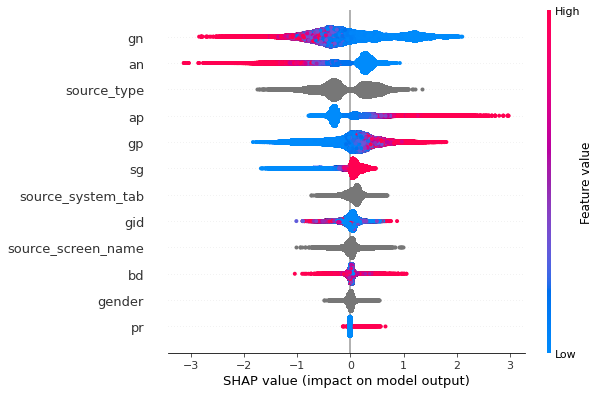

In [49]:
shap.summary_plot(shap_values, stack_x_val)